# Nano AI-QSAR model project: hyperparameters tuning with BayesSearchCV
Author:Kun Mi

Referred: Wei-Chun Chou (J Control Release. 2023 Sep;361:53-63. )  
Date created: 2024/01/10  
Final version date :2024/05/05

Description: In this study, we used machine learning and Deep nerual network model to predict Nanoparticles biodistribution

# Install and import required python pacakges

In [1]:
# Install python pacakges
#!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
!pip install -q lightgbm # install the lightgbm package
!pip install -q scikit-optimize # install the package used for Bayesian optimization
# !pip install -q scikeras[tensorflow]
!pip install -q tensorflow==2.15.0
!pip install -q keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 906.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [2]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time

# Link to google drive and set up your project folder

In [3]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/Colab Notebooks/Nano-AI-QSAR"

# choose where you want your project files to be saved
project_folder = "/Kidney/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Data exploration

In [4]:
# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Nano.csv"))

# Data preprocessing I: missing Values  
Most Machine leanring algorithms canot work with missing features. So, we need to use `SimpleImputer` to replace missing values with median, mean or frequently used values.

In [5]:
# see how many missing values in your dataset
Data.isna().sum()

No.                 0
Type                0
MAT                 0
TS                  0
CT                  0
TM                  0
Shape               0
Size               41
Zeta Potential     73
Admin              15
DE_tumor            0
DE_heart          195
DE_liver           78
DE_spleen         121
DE_lung           167
DE_kidney         138
dtype: int64

In [6]:
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta Potential','Admin','DE_kidney' ])

# you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column

In [7]:
#filter the outliers
df = pd.DataFrame(Data)
q_high=df["DE_kidney"].quantile(0.975)
q_low=df["DE_kidney"].quantile(0.025)
df_filtered=df[(df["DE_kidney"]<q_high)&(df["DE_kidney"]>q_low)]
df_X = df_filtered[["Type","MAT","TS", "CT","TM","Shape","Size","Zeta Potential","Admin" ]]
df_y = df_filtered[["DE_kidney"]]

In [8]:
## Replace mising value with "Mean" or "Frequency values"
imputer_mean = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer_freq = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
cols_num = ['Size','Zeta Potential','Admin']
cols_label = ['Type','MAT','TS','CT','TM','Shape']

imputer_mean = imputer_mean.fit(df_X[cols_num])
imputer_freq = imputer_freq.fit(df_X[cols_label])
df_X[cols_num] = imputer_mean.transform(df_X[cols_num])
df_X[cols_label] = imputer_freq.transform(df_X[cols_label])


<ipython-input-8-1f220070d19f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X[cols_num] = imputer_mean.transform(df_X[cols_num])
<ipython-input-8-1f220070d19f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X[cols_label] = imputer_freq.transform(df_X[cols_label])


# 3. Taking care of Categorical Features


In [9]:
test_X = df_X

In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode labels of multiple columns at once
test_X[cols_label] = test_X[cols_label].apply(LabelEncoder().fit_transform)

print(test_X)

     Type  MAT  TS  CT  TM  Shape      Size  Zeta Potential      Admin
2       1    1   0   0   2      3  1.623249           -5.00   1.000000
4       1    1   0   1   2      0  1.835056           -9.30   4.800000
17      1    1   0   0   2      0  1.382017          -21.30   2.000000
18      1    1   1   0   2      0  1.411620           21.70   2.000000
19      1    1   1   0   2      0  1.318063           24.60   2.000000
..    ...  ...  ..  ..  ..    ...       ...             ...        ...
525     2    8   1   8   2      3  1.344392           -0.80  40.200000
526     2    8   1   8   2      3  1.686636           -0.11  40.200000
527     1    6   0   1   3      3  1.843507          -12.90   3.375000
528     2    7   0   1   2      3  2.203577          -10.98   3.504599
529     2    7   0   1   2      3  2.208979          -10.76   3.504599

[298 rows x 9 columns]


<ipython-input-10-8492093ad7ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X[cols_label] = test_X[cols_label].apply(LabelEncoder().fit_transform)


# 4. Model normalization


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
cols_num = ['Size','Zeta Potential','Admin']

scaler = StandardScaler()
mscaler = MinMaxScaler()

Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)
print(Data_num_tr)

         Size  Zeta Potential     Admin
0    0.534939        0.416220  0.000774
1    0.630002        0.383321  0.003715
2    0.426670        0.291507  0.001548
3    0.439956        0.620505  0.001548
4    0.397966        0.642693  0.001548
..        ...             ...       ...
293  0.409783        0.448355  0.031115
294  0.563388        0.453634  0.031115
295  0.633795        0.355777  0.002612
296  0.795400        0.370467  0.002713
297  0.797825        0.372150  0.002713

[298 rows x 3 columns]


# Onehot encoder

In [12]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
cols_label_1hot = ['Type','MAT','TS','CT','TM','Shape']
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

print(data_cat_1hot)

     Type_0  Type_1  Type_2  MAT_0  MAT_1  MAT_2  MAT_3  MAT_4  MAT_5  MAT_6  \
0       0.0     1.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
1       0.0     1.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
2       0.0     1.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
3       0.0     1.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
4       0.0     1.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
..      ...     ...     ...    ...    ...    ...    ...    ...    ...    ...   
293     0.0     0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
294     0.0     0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
295     0.0     1.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
296     0.0     0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
297     0.0     0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

     ...  CT_11  CT_12  TM_0  TM_1  TM_

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
cols_label_bi = ['Type','MAT','TS','CT','TM','Shape']
data_cat_bi = test_X[cols_label_bi]
preData=pd.concat([Data_num_tr, data_cat_1hot], axis=1)
print(preData)

         Size  Zeta Potential     Admin  Type_0  Type_1  Type_2  MAT_0  MAT_1  \
0    0.534939        0.416220  0.000774     0.0     1.0     0.0    0.0    1.0   
1    0.630002        0.383321  0.003715     0.0     1.0     0.0    0.0    1.0   
2    0.426670        0.291507  0.001548     0.0     1.0     0.0    0.0    1.0   
3    0.439956        0.620505  0.001548     0.0     1.0     0.0    0.0    1.0   
4    0.397966        0.642693  0.001548     0.0     1.0     0.0    0.0    1.0   
..        ...             ...       ...     ...     ...     ...    ...    ...   
293  0.409783        0.448355  0.031115     0.0     0.0     1.0    0.0    0.0   
294  0.563388        0.453634  0.031115     0.0     0.0     1.0    0.0    0.0   
295  0.633795        0.355777  0.002612     0.0     1.0     0.0    0.0    0.0   
296  0.795400        0.370467  0.002713     0.0     0.0     1.0    0.0    0.0   
297  0.797825        0.372150  0.002713     0.0     0.0     1.0    0.0    0.0   

     MAT_2  MAT_3  ...  CT_

# Feature selection

In [14]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# generate dataset
#X, y = make_regression(n_samples=100, n_features=100, n_informative=10)
# define feature selection
fs = SelectKBest(score_func=f_regression, k=5)
# apply feature selection
X_selected = pd.DataFrame(fs.fit_transform(preData, df_y['DE_kidney']))
cols = fs.get_feature_names_out()
X_selected.columns = cols
print(X_selected)

     MAT_0  MAT_1  MAT_3  CT_3  CT_9
0      0.0    1.0    0.0   0.0   0.0
1      0.0    1.0    0.0   0.0   0.0
2      0.0    1.0    0.0   0.0   0.0
3      0.0    1.0    0.0   0.0   0.0
4      0.0    1.0    0.0   0.0   0.0
..     ...    ...    ...   ...   ...
293    0.0    0.0    0.0   0.0   0.0
294    0.0    0.0    0.0   0.0   0.0
295    0.0    0.0    0.0   0.0   0.0
296    0.0    0.0    0.0   0.0   0.0
297    0.0    0.0    0.0   0.0   0.0

[298 rows x 5 columns]


In [15]:
y_re = df_y['DE_kidney']
X_re = preData

In [16]:
y_re_LR = df_y['DE_kidney']
X_re_LR = X_selected

#Linear regression

In [ ]:
## Split the data after feature selection
from sklearn.model_selection import train_test_split
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_re_LR, y_re_LR, test_size = 0.2, random_state=2)

In [ ]:
#Install packae
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC,SVR
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [ ]:
LR_parm_search = [
    { # linear
     'alpha': Real(15, 20, prior='log-uniform'),
    #  "solver":Categorical(['auto']),
    }]


cv = KFold(n_splits=5, shuffle=True, random_state=77)

bs_LR = BayesSearchCV(
       estimator=Ridge(),
       search_spaces=LR_parm_search,
       cv = cv,
       n_iter = 20,
       n_jobs = -1,
       scoring = "r2",
       return_train_score=True,
       random_state = 2)

np.int=int

bs_LR.fit(X_train_LR, y_train_LR)

model_LR   = bs_LR.best_estimator_
test_preds_LR = model_LR.predict(X_test_LR)
train_preds_LR = model_LR.predict(X_train_LR)
all_preds_LR  = model_LR.predict(X_re_LR)
y_obs_LR    = y_re_LR.tolist()

r2_kfolds_LR = cross_val_score(model_LR, X_train_LR, y_train_LR, cv = cv, n_jobs=-1, scoring='r2')
rmse_kfolds_LR = cross_val_score(model_LR,X_train_LR, y_train_LR, cv = cv, n_jobs=-1, scoring='neg_root_mean_squared_error')

print('\nThe 5-CV rmse Score was:', rmse_kfolds_LR.mean())
print('With a standard deviation of:', rmse_kfolds_LR.std())
print('Test rmse socre: %.2f' %mse(y_test_LR, test_preds_LR, squared=False))

print('\nThe 5-CV R2 Score was:', r2_kfolds_LR.mean())
print('With a standard deviation of:', r2_kfolds_LR.std())
print("Test R2 Score : %.2f" %r2_score(y_test_LR, test_preds_LR))
print("Train R2 Score : %.2f" %r2_score(y_train_LR, train_preds_LR))
print("All R2 Score : %.2f" %r2_score(y_obs_LR, all_preds_LR))


The 5-CV rmse Score was: -2.0543676568960914
With a standard deviation of: 0.19636139327729746
Test rmse socre: 2.00

The 5-CV R2 Score was: 0.00015098227030914125
With a standard deviation of: 0.017658277352413994
Test R2 Score : 0.04
Train R2 Score : 0.03
All R2 Score : 0.03


In [ ]:
bs_LR.best_params_

OrderedDict([('alpha', 20.000000000000004)])

# SVM, RF, XGBoost and LGBM

In [ ]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC,SVR
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import Ridge

In [ ]:
models_to_run = [
                 SVR(),
                RandomForestRegressor(),
                 xgb.XGBRegressor(),
                  lgb.LGBMRegressor()
                ]

model_parm_search = [
    { # SVR
    #  'C': Real(1e-6, 1e+6, prior='log-uniform'),
     "kernel":Categorical(['linear','poly','rbf','sigmoid']),
     'gamma':Real(1e-6,11, prior='log-uniform'),
     "epsilon":Real(0,1),
    },

    { # RandomForestRegressor
     'max_depth': Integer(3, 12),
     'n_estimators': Integer(100, 1000),
     'max_features': Integer(10, 38),
    },

    { # 2nd param grid, corresponding to XGBRegressor
     'learning_rate': Real(1e-6, 1, 'log-uniform'),
      'max_depth': Integer(0,50),
      # "subsample": Real(0.1,1.0,'log-uniform'),
      #  'colsample_bytree': Real(0.1, 0.9,'log-uniform'),
      # 'n_estimators': Integer(50, 2000),
      'reg_alpha': Real(1e-5, 10,'log-uniform'),
      'reg_lambda': Real(1e-5, 20,'log-uniform'),
     },

    { # LGBMRegressor
     'learning_rate': Real(1e-6, 10, 'log-uniform'),
    'n_estimators': Integer(10, 2000),
     'max_depth': Integer(1,50),
     'reg_alpha': Real(1e-3, 20,'log-uniform'),
     'reg_lambda': Real(1e-3, 20,'log-uniform'),
    #  'num_leaves':Integer(2,10),
     'min_data_in_leaf':[4],
      'verbose':[-1],
    }
]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.2, random_state=42)


In [ ]:
from sklearn.metrics import mean_squared_error as mse

cv = KFold(n_splits=5, shuffle=True, random_state=77)

for i, model in enumerate(models_to_run):
   # build the Bayesian search model

   bs = BayesSearchCV(
       estimator=model,
       search_spaces=model_parm_search[i],
       cv = cv,
       n_iter = 20,
       n_jobs = -1,
       scoring = "r2",
       return_train_score=True,
       random_state = 2)

   bs.fit(X_train, y_train)

   model    = bs.best_estimator_
   test_preds = model.predict(X_test)
   train_preds = model.predict(X_train)
   all_preds  = model.predict(X_re)
   y_obs    = y_re.tolist()

   r2_kfolds = cross_val_score(model, X_train, y_train, cv = cv, n_jobs=-1, scoring='r2')
   rmse_kfolds = cross_val_score(model, X_train, y_train, cv = cv, n_jobs=-1, scoring='neg_root_mean_squared_error')

   print('\nThe 5-CV rmse Score was:', rmse_kfolds.mean())
   print('With a standard deviation of:', rmse_kfolds.std())
   print('Test rmse socre: %.2f' %mse(y_test, test_preds, squared=False))

   print('\nThe 5-CV R2 Score was:', r2_kfolds.mean())
   print('With a standard deviation of:', r2_kfolds.std())
   print("Test R2 Score : %.2f" %r2_score(y_test, test_preds))
   print("Train R2 Score : %.2f" %r2_score(y_train, train_preds))
   print("All R2 Score : %.2f" %r2_score(y_obs, all_preds))


The 5-CV rmse Score was: -1.8818615634100866
With a standard deviation of: 0.30824762784083903
Test rmse socre: 2.32

The 5-CV R2 Score was: 0.08281850672497504
With a standard deviation of: 0.06352429465572015
Test R2 Score : 0.02
Train R2 Score : 0.39
All R2 Score : 0.29

The 5-CV rmse Score was: -1.8134403858291503
With a standard deviation of: 0.3987490104630687
Test rmse socre: 1.98

The 5-CV R2 Score was: 0.14729421152952868
With a standard deviation of: 0.15914959443060128
Test R2 Score : 0.29
Train R2 Score : 0.88
All R2 Score : 0.72

The 5-CV rmse Score was: -1.8427836409820375
With a standard deviation of: 0.3550080966243956
Test rmse socre: 2.10

The 5-CV R2 Score was: 0.11477611620939551
With a standard deviation of: 0.15666903450692268
Test R2 Score : 0.19
Train R2 Score : 0.60
All R2 Score : 0.50

The 5-CV rmse Score was: -1.9209787816035107
With a standard deviation of: 0.3598511603640984
Test rmse socre: 2.11

The 5-CV R2 Score was: 0.03751139547861411
With a standard 

# Deep nerual network model with keras

In [17]:
# import basic packages
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
# import scikeras
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl

# import keras related packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
from keras.callbacks import EarlyStopping
# from keras.wrappers.scikit_learn import KerasRegressor
from keras_tuner import BayesianOptimization
from keras_tuner import Hyperband
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [18]:
X = X_re.to_numpy()
y = y_re.to_numpy()
# summarize shape
print(X.shape, y.shape)


(298, 39) (298,)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=2)

# Tuning Model with Keras Tuner

In [ ]:
def build_model(hp):
  model = Sequential()

  # Input layer
  model.add(Dense(units = hp.Int('dense-bot', min_value=38,
             max_value=256, step=12, default=38),#256
             activation = hp.Choice(
                 'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),
             input_shape=(X.shape[1],)))


  # Tune the number of units in the each dense layer
  for i in range (hp.Int('num_dense_layers',1,5)):
    model.add(Dense(units=hp.Int('dense_'+str(i), min_value=38, max_value=512, step=60),
          activation = hp.Choice('act_l1',['relu','tanh','sigmoid'])))

    # Tune the droput rate in the each dense layer
    model.add(Dropout(hp.Float('dropout_'+ str(i), min_value=0.0, max_value=0.5, step=0.2)))


  # add output
  model.add(layers.Dense(1,activation='linear'))

  hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

  if hp_optimizer == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8, 1e-9])

  elif hp_optimizer == 'SGD':
     hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8, 1e-9])
     nesterov=True
     momentum=0.9

  model.compile(
    optimizer=hp_optimizer,
    loss='mse',
    metrics=['mse'])

  return model

In [ ]:
# Check if the model code work correctly
import keras_tuner
build_model(keras_tuner.HyperParameters())


In [ ]:
tuner_bo = BayesianOptimization(
            hypermodel = build_model,
            objective = 'val_mse',
            max_trials = 10, #10
            overwrite = True,
            executions_per_trial=1)

In [ ]:
tuner_bo.search(X_train, y_train,
         validation_data = (X_test, y_test),
         batch_size = 32,
         epochs = 2000, #1800
         verbose = 0)

In [ ]:
# Get the top 2 models
best_params=tuner_bo.get_best_hyperparameters()
best_params[0].values

{'dense-bot': 242,
 'dense_activation': 'tanh',
 'num_dense_layers': 5,
 'dense_0': 218,
 'act_l1': 'sigmoid',
 'dropout_0': 0.4,
 'Optimizer': 'Adam',
 'learning_rate': 0.0001,
 'dense_1': 158,
 'dropout_1': 0.0,
 'dense_2': 218,
 'dropout_2': 0.2,
 'dense_3': 278,
 'dropout_3': 0.2,
 'dense_4': 278,
 'dropout_4': 0.4}

In [ ]:
best_model= tuner_bo.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 242)               9680      
                                                                 
 dense_1 (Dense)             (None, 218)               52974     
                                                                 
 dropout (Dropout)           (None, 218)               0         
                                                                 
 dense_2 (Dense)             (None, 158)               34602     
                                                                 
 dropout_1 (Dropout)         (None, 158)               0         
                                                                 
 dense_3 (Dense)             (None, 218)               34662     
                                                                 
 dropout_2 (Dropout)         (None, 218)               0

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

test_preds = best_model.predict(X_test)
train_preds = best_model.predict(X_train)
all_preds  = best_model.predict(X_re)
y_obs    = y_re.tolist()

# print("\nTest R2 Score : %.2f" %r2_score(y_test, test_preds))
# print("Train R2 Score : %.2f" %r2_score(y_train, train_preds))
# print("All R2 Score : %.2f" %r2_score(y_obs, all_preds))
# print("Test rmse socre: %.2f" %mean_squared_error(y_test, test_preds, squared=False))

In [ ]:
# # save model and architecture to single file
# best_model.save("DL_kidney_best_model_outlier.h5")
# print("Saved model to disk")

Saved model to disk


#Load the best DNN model

In [20]:
best_model_v2 = load_model('DL_kidney_best_model.h5')
test_preds_v2 = best_model_v2.predict(X_test)
train_preds_v2 = best_model_v2.predict(X_train)
all_preds_v2  = best_model_v2.predict(X_re)
y_obs    = y_re.tolist()

# print("\nTest R2 Score : %.2f" %r2_score(y_test, test_preds_v2))
# print("Train R2 Score : %.2f" %r2_score(y_train, train_preds_v2))
print("All R2 Score : %.2f" %r2_score(y_obs, all_preds_v2))
print('All rmse socre: %.2f' %mse(y_obs, all_preds_v2, squared=False))

print("\nTest R2 Score : %.2f" %r2_score(y_test, test_preds_v2))
print("Test rmse socre: %.2f" %mse(y_test, test_preds_v2, squared=False))
print("Train R2 Score : %.2f" %r2_score(y_train, train_preds_v2))
print("Train rmse socre: %.2f" %mse(y_train, train_preds_v2, squared=False))

10/10 [==============================] - 0s 4ms/step
All R2 Score : 0.82
All rmse socre: 0.87

Test R2 Score : 0.83
Test rmse socre: 0.85
Train R2 Score : 0.82
Train rmse socre: 0.87


In [ ]:
best_model_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 242)               9680      
                                                                 
 dense_1 (Dense)             (None, 218)               52974     
                                                                 
 dropout (Dropout)           (None, 218)               0         
                                                                 
 dense_2 (Dense)             (None, 158)               34602     
                                                                 
 dropout_1 (Dropout)         (None, 158)               0         
                                                                 
 dense_3 (Dense)             (None, 218)               34662     
                                                                 
 dropout_2 (Dropout)         (None, 218)               0

In [ ]:
# #Export the dataset
# pd.DataFrame(y_train).to_csv('DNNtrain.csv',index=False)
# pd.DataFrame(y_test).to_csv('DNNtest.csv',index=False)

# pd.DataFrame(train_preds_v2).to_csv('DNNtrain_pred.csv',index=False)
# pd.DataFrame(test_preds_v2).to_csv('DNNtest_pred.csv',index=False)

# Display the R-squared value on scatterplot with regression model

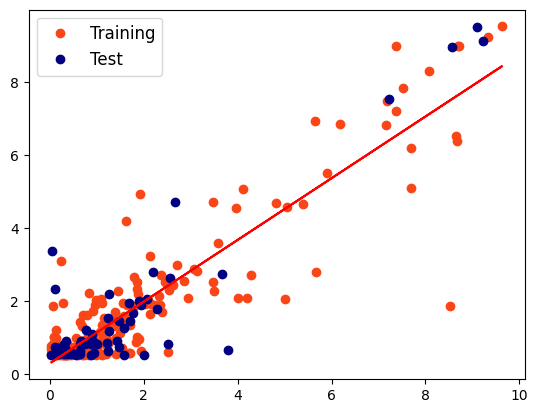

In [ ]:
import matplotlib.pyplot as plt

# create basic catterplot
plt.plot(y_train,train_preds_v2,'o',c="#FA4616",label="Training")
plt.plot(y_test,test_preds_v2,'o',c="#000080",label="Test")

# obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(y_obs, all_preds_v2, 1)

# add linear regression line to scatterplot
plt.legend(loc="upper left", fontsize=12)
plt.plot(y_obs, m*y_obs+b,c="red")
# plt.savefig("r2 kidney specific-0118",dpi=300)

# New Section

# K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse


dnn_best_model = best_model_v2

kfold = KFold(n_splits=5, shuffle=True, random_state=2)
cvr2scores = []
cvrmsescores = []

for train_ix, test_ix in kfold.split(X_train):
  # split data
  X_trian_n, X_test_n = X_train[train_ix], X_train[test_ix]
  y_trian_n, y_test_n = y_train[train_ix], y_train[test_ix]
  # create model

  dnn_best_model.fit(X_trian_n,y_trian_n, epochs=2000, batch_size=32, verbose=0)
  test_pred = dnn_best_model.predict(X_test_n)
  r2score = r2_score(y_test_n, test_pred)
  rmse   = mse(y_test_n, test_pred,squared=False)

  #print("Test R2 Score : %.2f" %r2score)
  #print("Test R2 Score : %.2f" %rmse)

  cvr2scores.append(r2score)
  cvrmsescores.append(rmse)

print("The 5-cv r2 Score was: %.2f (+/-) %.2f" % (np.mean(cvr2scores), np.std(cvr2scores)))
print("The 5-cv rmse Score was: %.2f (+/-) %.2f" % (np.mean(cvrmsescores), np.std(cvrmsescores)))


2/2 [==============================] - 0s 7ms/step
The 5-cv r2 Score was: 0.74 (+/-) 0.09
The 5-cv rmse Score was: 1.02 (+/-) 0.17


# Feature importance

In [ ]:
!pip install -q shap==0.44.1
import shap
import matplotlib.pyplot as pl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 4.7 MB/s eta 0:00:00


2/2 [==============================] - 0s 7ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

3313/3313 [==============================] - 8s 2ms/step


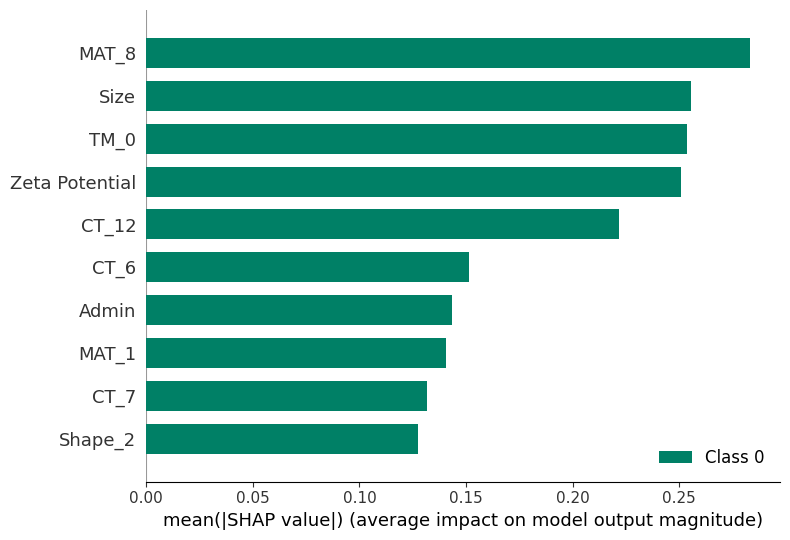

In [ ]:
## build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.KernelExplainer(best_model_v2.predict , shap.sample(X_train,50))
shap_values = explainer.shap_values(X_test)
shap.initjs()
features= preData.columns[0:39]

shap.summary_plot(shap_values, X_train, feature_names=features,color=pl.get_cmap("summer"),max_display=10)

In [ ]:
rf_resultX = pd.DataFrame(np.array(shap_values).squeeze())
vals = np.abs(rf_resultX.values).mean(0)
feature_names= preData.columns[0:39]
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
# shap_importance.sum(axis=1)

shap_importance.to_csv('importance_DE_kidney.csv', encoding = 'utf-8-sig',index=True)

# Save predicted values (to csv file)

In [ ]:
Pred_DE_kidney = pd.concat([pd.DataFrame(Data.dropna()["No."].reset_index(drop=True)), pd.DataFrame(y_obs), pd.DataFrame(all_preds_v2)], axis = 1)
Pred_DE_kidney.columns = ["No.","DE_kidney", "Pred_DE_kidney"]
Pred_DE_kidney.to_csv('output_DE_kidney.csv', encoding = 'utf-8-sig',index=False)